In [2]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from jax import lax, jit, vmap, partial
from jax.experimental import optimizers
from jax.nn import sigmoid, softplus
from jax.scipy.stats import bernoulli

# from rf_utils import get_psf_func, make_grid, make_receptive_fields, sequential_map

In [3]:
@jit
def softplus_inverse(x):
    return jnp.log(jnp.exp(x) - 1)

def fit_rf_ellipsoid(y, I, L, grid, niters=2000, learning_rate=5e-2):
    
    
    # initialize params. We'll use diagonal covariance for now.
    mu = jnp.mean(np.unique(L, axis=0), axis=0)
    covs = softplus_inverse(10 * jnp.ones(3))
    phi_0 = 1.0
    phi_1 = 5.0
    scale = 1.0
    
    def p_spike(params, data):
        y_k, I_k, L_k = data
        mu, covs, phi_0, phi_1, scale = params
        m_k = scale * jnp.exp(- (L_k - mu).T @ jnp.diag(1 / (I_k * softplus(covs))) @ (L_k - mu))
        return sigmoid(phi_0 * m_k - phi_1)

    def trial_likelihood(params, data):
        y_k, L_k, I_k = data
        return bernoulli.logpmf(y_k, p_spike(params, data))
    
    def get_loss_fun():
        _dataset_likelihood = vmap(trial_likelihood, in_axes=(None, (0,0,0)))
        def loss(params, data):
            likes = _dataset_likelihood(params, data)
            likes = jnp.nan_to_num(likes)
            return -jnp.sum(likes)
        return loss
    
    def get_predict_fun():
        return vmap(p_spike, in_axes=(None, (0,0,0)))
    
    # loss function setup
    init_params = (mu, covs, phi_0, phi_1, scale)
    loss = get_loss_fun()
    predict = get_predict_fun()
    
    # optimizer setup
    opt_init, opt_update, get_params = optimizers.adam(learning_rate)
    opt_state = opt_init(init_params)

    loss_hist = jnp.zeros(niters)
    
    @jit
    def step(step, opt_state):
        value, grads = jax.value_and_grad(loss, argnums=0)(get_params(opt_state), (y, I, L))
        opt_state = opt_update(step, grads, opt_state)
        return value, opt_state

    for i in range(niters):
        value, opt_state = step(i, opt_state)
        loss_hist = jax.ops.index_update(loss_hist, i, value)
        
    return loss_hist, get_params(opt_state), predict


def plot_filter_and_data(y, I, L, params):
    
    # make grid
    xr, yr, zr, pr = [sorted(x) for x in (np.unique(L[:, 0]), np.unique(L[:, 1]), np.unique(L[:, 2]), np.unique(I))]
    dims = [len(arr) for arr in [xr, yr, zr, pr]]
    xgrid, ygrid, zgrid, pgrid = np.meshgrid(xr, yr, zr, pr)
    grid = np.c_[xgrid.flatten(), ygrid.flatten(), zgrid.flatten(), pgrid.flatten()]

    # preds will be 16 x 16 x ndepths x npowers
    preds = predict(params, (jnp.zeros(len(grid)), grid[:,-1], grid[:,:-1])).reshape(dims)
    
    ndepths = len(zr)
    npowers = len(pr)
    density = make_receptive_fields(y, I, L)


    fontsize = 10
    plt.figure(figsize=(3*(npowers + 1), 1.5*ndepths))
    plt_cntr = 1
    for iz, zv in enumerate(zr):
        for ip, pv in enumerate(pr):
            
            plt.subplot(ndepths, 2 * npowers , plt_cntr)
            plt.imshow(density[..., ndepths - iz - 1, ip], origin='lower', vmin=0, vmax=1) # reverse order of zdim
            plt.xticks([])
            plt.yticks([])
            plt_cntr += 1
            if iz == 0:
                plt.title('%i mW (data)'%pv, fontsize=fontsize)

            plt.subplot(ndepths, 2 * npowers, plt_cntr)
            plt.imshow(preds[:,:,iz, ip].T, origin='lower', vmin=0, vmax=1)
            plt.xticks([])
            plt.yticks([])
            plt_cntr += 1
            if iz == 0:
                plt.title('%i mW (model)'%pv, fontsize=fontsize)
       


In [5]:
# filename = 'loose_patch/210418_cell9LPB_A.npz'
filename = '210422_cell5_LP_D_A.npz'
f = np.load(filename)
y, I, L = f['y'], f['I'], f['L']
grid = make_grid(y, I, L)


NameError: name 'make_grid' is not defined

In [160]:
loss, params, predict = fit_rf_ellipsoid(y, I, L, grid,)

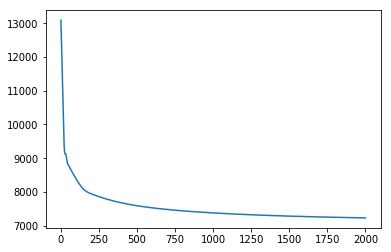

In [162]:
plt.plot(loss)

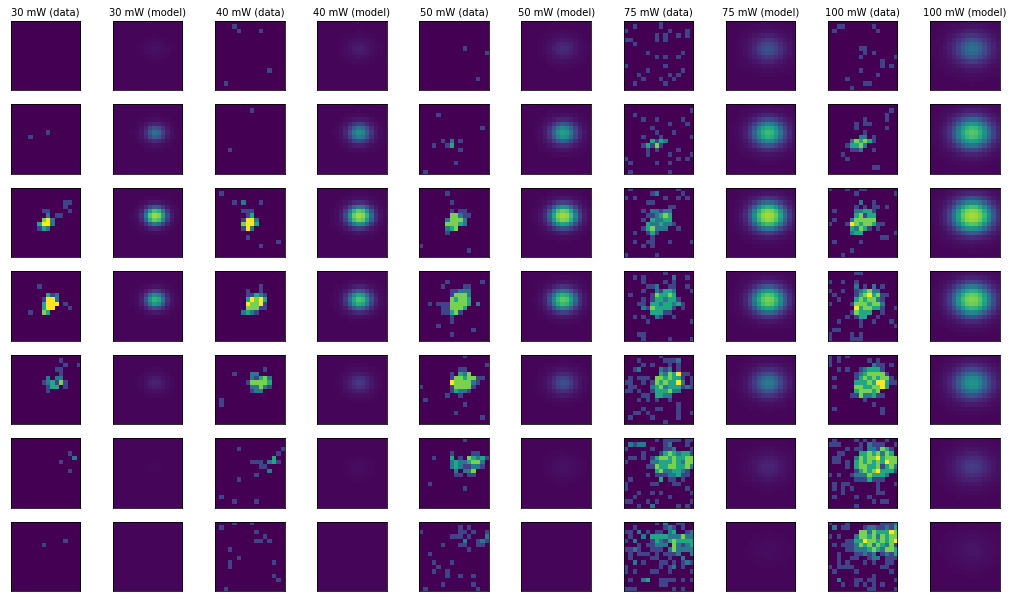

In [163]:
plot_filter_and_data(y, I, L, params)